# Notebook 1.4: LMPC with Input and Output Constraints

One of the primary strengths of Model Predictive Control is its ability to **explicitly handle constraints** on system inputs, outputs, and states. In Notebook 1.3, we implemented an unconstrained LMPC. Now, we will extend this to incorporate operational limits, which are ubiquitous in real-world applications.

These constraints are added to the Quadratic Program (QP) as linear inequalities, and the QP solver will find the optimal control sequence that respects these bounds.

**Goals of this Notebook:**
1. Learn how to formulate common linear constraints for MPC:
    a. Input magnitude constraints ($u_{min}, u_{max}$).
    b. Input rate of change constraints ($\Delta u_{min}, \Delta u_{max}$).
    c. Output constraints ($y_{min}, y_{max}$). 
2. Modify the QP problem in `CVXPY` to include these linear inequality constraints.
3. Implement and simulate a constrained LMPC controller for the double integrator.
4. Visualize how the controller respects the defined limits and how active constraints affect performance.
5. Understand the concept of feasibility in constrained MPC.

## 1. Importing Libraries and Re-using Code

We'll continue using NumPy, Matplotlib, SciPy, and CVXPY. We'll reuse most of the setup from Notebook 1.3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
import cvxpy as cp

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 8)})

# --- Code from Notebook 1.1, 1.2, 1.3 ---
# System Definition (Double Integrator)
Ac = np.array([[0, 1], [0, 0]])
Bc = np.array([[0], [1]])
Cc = np.array([[1, 0]])
Dc = np.array([[0]])
Ts = 0.1
Ad, Bd, Cd, Dd, _ = cont2discrete((Ac, Bc, Cc, Dc), Ts, method='zoh')
n_states = Ad.shape[0]
n_inputs = Bd.shape[1]
n_outputs = Cd.shape[0]

# Prediction Matrices Function
def get_prediction_matrices(Ad_sys, Bd_sys, Cd_sys, Np_horizon):
    n_s = Ad_sys.shape[0]
    n_i = Bd_sys.shape[1]
    n_o = Cd_sys.shape[0]
    F = np.zeros((n_o * Np_horizon, n_s))
    Phi = np.zeros((n_o * Np_horizon, n_i * Np_horizon))
    for i in range(Np_horizon):
        F[i*n_o:(i+1)*n_o, :] = Cd_sys @ np.linalg.matrix_power(Ad_sys, i + 1)
        for j in range(i + 1):
            if i-j == 0:
                 Phi[i*n_o:(i+1)*n_o, j*n_i:(j+1)*n_i] = Cd_sys @ Bd_sys
            else:
                 Phi[i*n_o:(i+1)*n_o, j*n_i:(j+1)*n_i] = Cd_sys @ np.linalg.matrix_power(Ad_sys, i-j) @ Bd_sys
    return F, Phi

# QP Matrix Builder (modified to return T_diff and U_prev_stacked_func)
def build_qp_components(F_mat, Phi_mat, Q_val, R_val, S_val, Np_h, m_ins, p_outs):
    Q_matrix_s = Q_val * np.eye(p_outs)
    R_matrix_s = R_val * np.eye(m_ins)
    S_matrix_s = S_val * np.eye(m_ins)
    Q_bar_s = np.kron(np.eye(Np_h), Q_matrix_s)
    R_bar_s = np.kron(np.eye(Np_h), R_matrix_s)
    S_bar_s = np.kron(np.eye(Np_h), S_matrix_s)
    
    T_diff_s = np.zeros((Np_h * m_ins, Np_h * m_ins))
    for i in range(Np_h):
        T_diff_s[i*m_ins:(i+1)*m_ins, i*m_ins:(i+1)*m_ins] = np.eye(m_ins)
        if i > 0:
            T_diff_s[i*m_ins:(i+1)*m_ins, (i-1)*m_ins:i*m_ins] = -np.eye(m_ins)
            
    H_qp_s = 2 * (Phi_mat.T @ Q_bar_s @ Phi_mat + R_bar_s + T_diff_s.T @ S_bar_s @ T_diff_s)
    
    def compute_f_qp_inner(xk_curr, R_traj_v, u_prev_curr):
        U_prev_stacked_s = np.zeros((Np_h * m_ins, 1))
        U_prev_stacked_s[0:m_ins, 0] = u_prev_curr.flatten()
        error_term_Fx_R_s = F_mat @ xk_curr - R_traj_v
        f_qp_s = 2 * (Phi_mat.T @ Q_bar_s @ error_term_Fx_R_s - T_diff_s.T @ S_bar_s @ U_prev_stacked_s)
        return f_qp_s
        
    # Return T_diff for constructing rate constraints
    # Return a function for U_prev_stacked as it also depends on u_prev_curr
    def get_U_prev_stacked_inner(u_prev_curr):
        U_prev_stacked_s = np.zeros((Np_h * m_ins, 1))
        U_prev_stacked_s[0:m_ins, 0] = u_prev_curr.flatten()
        return U_prev_stacked_s

    return H_qp_s, compute_f_qp_inner, T_diff_s, get_U_prev_stacked_inner

# MPC Parameters
Np = 20      # Prediction Horizon
Qw = 100.0   # Output error weight
Rw = 0.1    # Input magnitude weight
Sw = 1.0     # Input rate weight

F_mpc, Phi_mpc = get_prediction_matrices(Ad, Bd, Cd, Np)
H_qp_mpc, compute_f_qp_mpc_func, T_diff_mpc, get_U_prev_stacked_mpc_func = \
    build_qp_components(F_mpc, Phi_mpc, Qw, Rw, Sw, Np, n_inputs, n_outputs)

## 2. Formulating Constraints

The decision variable in our QP is $\mathbf{U}_k = [u_{k|k}^T, u_{k+1|k}^T, \dots, u_{k+N_p-1|k}^T]^T$, a vector of size $N_p m \times 1$.
Constraints will be expressed as linear inequalities $G \mathbf{U}_k \le h$ or $A_{eq} \mathbf{U}_k = b_{eq}$ (though we won't use equality constraints in this basic example).

### 2.1 Input Magnitude Constraints

$u_{min,i} \le u_{k+j|k, i} \le u_{max,i}$ for each input $i=1...m$ and each time step $j=0...N_p-1$.

In matrix form for $\mathbf{U}_k$:
$\mathbf{U}_k \le \mathbf{U}_{max}$ (vector of upper bounds repeated for $N_p$ steps)
$\mathbf{U}_k \ge \mathbf{U}_{min}$ (or $-\mathbf{U}_k \le -\mathbf{U}_{min}$)

In [2]:
# Define input constraints for the double integrator (single input)
u_min = -1.0  # Minimum force
u_max = 1.0   # Maximum force

# Create constraint matrices for CVXPY
# U_vec will be the CVXPY variable for U_k (Np*m_inputs x 1)
U_max_vec = np.tile(u_max, (Np * n_inputs, 1))
U_min_vec = np.tile(u_min, (Np * n_inputs, 1))

### 2.2 Input Rate of Change Constraints

$\Delta u_{min,i} \le \Delta u_{k+j|k, i} \le \Delta u_{max,i}$ for each input $i$ and $j=0...N_p-1$.
Recall $\Delta \mathbf{U}_k = \mathbf{T}_{diff} \mathbf{U}_k - \mathbf{U}_{prev}$.
So, $\mathbf{T}_{diff} \mathbf{U}_k - \mathbf{U}_{prev} \le \mathbf{\Delta U}_{max}$
And $\mathbf{T}_{diff} \mathbf{U}_k - \mathbf{U}_{prev} \ge \mathbf{\Delta U}_{min}$ (or $-(\mathbf{T}_{diff} \mathbf{U}_k - \mathbf{U}_{prev}) \le -\mathbf{\Delta U}_{min}$)

In [3]:
# Define input rate constraints
delta_u_min = -0.2 # Max decrease in force per Ts
delta_u_max = 0.2  # Max increase in force per Ts

Delta_U_max_vec = np.tile(delta_u_max, (Np * n_inputs, 1))
Delta_U_min_vec = np.tile(delta_u_min, (Np * n_inputs, 1))

### 2.3 Output Constraints

$y_{min,l} \le \hat{y}_{k+j|k, l} \le y_{max,l}$ for each output $l=1...p$ and $j=1...N_p$.
Since $\mathbf{Y}_k = \mathbf{F} x_k + \mathbf{\Phi} \mathbf{U}_k$, these become:
$\mathbf{F} x_k + \mathbf{\Phi} \mathbf{U}_k \le \mathbf{Y}_{max}$
$\mathbf{F} x_k + \mathbf{\Phi} \mathbf{U}_k \ge \mathbf{Y}_{min}$

Rearranging for $\mathbf{U}_k$:
$\mathbf{\Phi} \mathbf{U}_k \le \mathbf{Y}_{max} - \mathbf{F} x_k$
$-\mathbf{\Phi} \mathbf{U}_k \le -\mathbf{Y}_{min} + \mathbf{F} x_k$

In [4]:
# Define output constraints (for position, which is output y1)
y_min_pos = -0.5 # Minimum allowed position
y_max_pos = 1.2  # Maximum allowed position

# Y_max_vec and Y_min_vec will be Np*n_outputs x 1
Y_max_target_vec = np.tile(y_max_pos, (Np * n_outputs, 1))
Y_min_target_vec = np.tile(y_min_pos, (Np * n_outputs, 1))

## 3. Solving the Constrained QP with CVXPY

We will modify the `solve_qp_cvxpy` function to include these constraints. The constraint expressions involving $x_k$ and $u_{k-1}$ mean that the right-hand side of some inequality constraints will change at each time step $k$.

In [5]:
def solve_constrained_qp_cvxpy(H_qp, f_qp_val, 
                                 F_mat, Phi_mat, T_diff_mat, U_prev_stacked_val,
                                 xk_curr_val, 
                                 u_min_val, u_max_val, 
                                 delta_u_min_val, delta_u_max_val, 
                                 y_min_pred_rhs_val, y_max_pred_rhs_val, 
                                 solver=cp.OSQP):
    """
    Solves a constrained QP problem for MPC.
    y_min_pred_rhs_val = -Y_min_target + F_mat @ xk_curr_val
    y_max_pred_rhs_val =  Y_max_target - F_mat @ xk_curr_val
    """
    num_vars_U = H_qp.shape[0] # Should be Np * n_inputs
    U_decision_var = cp.Variable(num_vars_U)
    
    H_qp_symmetric = 0.5 * (H_qp + H_qp.T)
    objective = cp.Minimize(0.5 * cp.quad_form(U_decision_var, H_qp_symmetric) + f_qp_val.flatten() @ U_decision_var)
    
    constraints = []
    
    # Input magnitude constraints
    if u_min_val is not None:
        constraints += [U_decision_var >= np.tile(u_min_val, num_vars_U // U_decision_var.shape[0] * n_inputs)] # If u_min_val is scalar
    if u_max_val is not None:
        constraints += [U_decision_var <= np.tile(u_max_val, num_vars_U // U_decision_var.shape[0] * n_inputs)]
        
    # Input rate constraints: delta_u_min <= T_diff @ U - U_prev_stacked <= delta_u_max
    delta_U = T_diff_mat @ U_decision_var - U_prev_stacked_val.flatten()
    if delta_u_min_val is not None:
        constraints += [delta_U >= np.tile(delta_u_min_val, num_vars_U // U_decision_var.shape[0] * n_inputs)]
    if delta_u_max_val is not None:
        constraints += [delta_U <= np.tile(delta_u_max_val, num_vars_U // U_decision_var.shape[0] * n_inputs)]
        
    # Output constraints: Y_min - Fx <= Phi @ U <= Y_max - Fx
    # Predicted_Y = Phi_mat @ U_decision_var (This is only forced response part for QP constraints)
    # Full Y_pred_for_constraints = F_mat @ xk_curr_val + Phi_mat @ U_decision_var
    # So, Y_min_target <= Fx + PhiU <= Y_max_target
    # PhiU <= Y_max_target - Fx  (this is y_max_pred_rhs_val passed in)
    # PhiU >= Y_min_target - Fx  (this is y_min_pred_rhs_val passed in, if y_min_pred_rhs_val = Y_min_target - Fx)
    if y_min_pred_rhs_val is not None: # y_min_pred_rhs_val = Y_min_target_vec - F_mat @ xk_curr_val
        constraints += [Phi_mat @ U_decision_var >= y_min_pred_rhs_val.flatten()]
    if y_max_pred_rhs_val is not None: # y_max_pred_rhs_val = Y_max_target_vec - F_mat @ xk_curr_val
        constraints += [Phi_mat @ U_decision_var <= y_max_pred_rhs_val.flatten()]

    problem = cp.Problem(objective, constraints)
    
    try:
        problem.solve(solver=solver, verbose=False)
        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            return U_decision_var.value.reshape(-1, 1)
        elif problem.status == cp.INFEASIBLE or problem.status == cp.INFEASIBLE_INACCURATE:
            print(f"QP INFEASIBLE. Status: {problem.status}")
            return None
        else:
            print(f"QP solution failed or suboptimal. Status: {problem.status}")
            return None
    except Exception as e:
        print(f"Error during constrained QP solve: {e}")
        return None

## 4. Implementing the Constrained LMPC Loop

The loop is similar to the unconstrained case, but now we call the `solve_constrained_qp_cvxpy` function and need to compute the RHS of the output constraints at each step.

In [6]:
# Simulation Parameters
sim_steps_constrained = 100

# Plant
x_plant_c = np.array([[0.0], [0.0]])    # Initial state
u_prev_plant_c = np.array([[0.0]]) # Previous input

# Reference trajectory
setpoint_c = 1.0
R_traj_target_c = np.ones((Np * n_outputs, 1)) * setpoint_c

# Data logging
X_log_c = np.zeros((n_states, sim_steps_constrained + 1))
Y_log_c = np.zeros((n_outputs, sim_steps_constrained))
U_log_c = np.zeros((n_inputs, sim_steps_constrained))
X_log_c[:, 0] = x_plant_c.flatten()

# Get H_qp (constant part), and functions to get f_qp and U_prev_stacked
H_qp_constr_mpc, compute_f_qp_constr_func, T_diff_constr_mpc, get_U_prev_stacked_constr_func = \
    build_qp_components(F_mpc, Phi_mpc, Qw, Rw, Sw, Np, n_inputs, n_outputs)

print(f"Starting constrained LMPC simulation for {sim_steps_constrained} steps...")
infeasible_count = 0

for k_sim in range(sim_steps_constrained):
    print(f"Sim step {k_sim+1}/{sim_steps_constrained}", end='\r')
    x_current_plant_c = X_log_c[:, k_sim].reshape(n_states, 1)
    
    # Compute f_qp for current state and reference
    f_qp_current_c = compute_f_qp_constr_func(x_current_plant_c, R_traj_target_c, u_prev_plant_c)
    
    # Compute U_prev_stacked for rate constraints
    U_prev_stacked_current = get_U_prev_stacked_constr_func(u_prev_plant_c)
    
    # Compute RHS for output constraints
    # PhiU <= Y_max_target_vec - Fx 
    # PhiU >= Y_min_target_vec - Fx
    y_max_rhs = Y_max_target_vec - F_mpc @ x_current_plant_c
    y_min_rhs = Y_min_target_vec - F_mpc @ x_current_plant_c
    
    # Solve constrained QP
    U_optimal_seq_c = solve_constrained_qp_cvxpy(
        H_qp_constr_mpc, f_qp_current_c,
        F_mpc, Phi_mpc, T_diff_constr_mpc, U_prev_stacked_current,
        x_current_plant_c, # Not directly used by solver, but for forming RHS of y_constraints
        u_min, u_max,
        delta_u_min, delta_u_max,
        y_min_rhs, y_max_rhs # Pass the calculated RHS for y constraints
    )
    
    if U_optimal_seq_c is None:
        print(f"Constrained QP Solver failed or INFEASIBLE at step {k_sim+1}. Holding previous input.")
        u_applied_c = u_prev_plant_c
        infeasible_count += 1
    else:
        u_applied_c = U_optimal_seq_c[0:n_inputs, 0].reshape(n_inputs, 1)
    
    U_log_c[:, k_sim] = u_applied_c.flatten()
    
    # Plant evolves
    x_next_plant_c = Ad @ x_current_plant_c + Bd @ u_applied_c
    y_log_val_c = Cd @ x_current_plant_c # y_k = C x_k
    Y_log_c[:, k_sim] = y_log_val_c.flatten()
    X_log_c[:, k_sim + 1] = x_next_plant_c.flatten()
    
    u_prev_plant_c = u_applied_c

print(f"\nConstrained LMPC simulation finished. Infeasible steps: {infeasible_count}")

Starting constrained LMPC simulation for 100 steps...
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
P

## 5. Visualizing Constrained Closed-Loop Performance

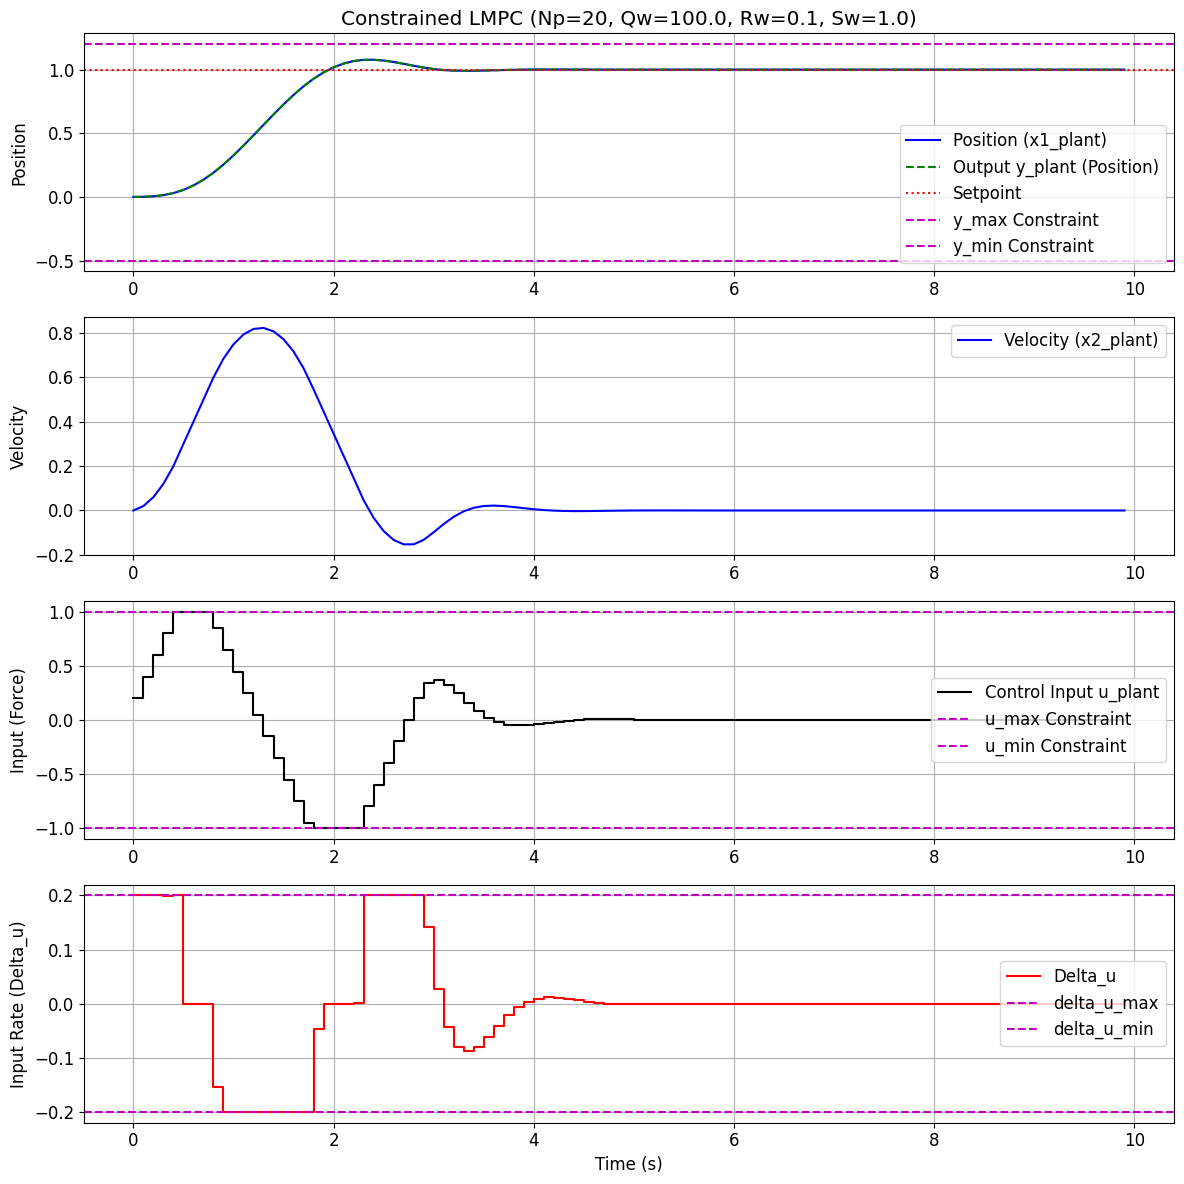

In [8]:
time_vec_c = np.arange(0, sim_steps_constrained * Ts, Ts)
time_vec_states_c = np.arange(0, (sim_steps_constrained + 1) * Ts, Ts)

plt.figure(figsize=(12, 12))

plt.subplot(4,1,1)
plt.plot(time_vec_c, X_log_c[0,:-1], 'b-', label='Position (x1_plant)')  # Use :-1 to exclude last state
plt.plot(time_vec_c, Y_log_c[0,:], 'g--', label='Output y_plant (Position)')
plt.axhline(setpoint_c, color='r', linestyle=':', label='Setpoint')
if y_max_pos is not None: plt.axhline(y_max_pos, color='m', linestyle='--', label='y_max Constraint')
if y_min_pos is not None: plt.axhline(y_min_pos, color='m', linestyle='--', label='y_min Constraint')
plt.title(f'Constrained LMPC (Np={Np}, Qw={Qw}, Rw={Rw}, Sw={Sw})')
plt.ylabel('Position')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(4,1,2)
plt.plot(time_vec_c, X_log_c[1,:-1], 'b-', label='Velocity (x2_plant)')  # Use :-1 to exclude last state
plt.ylabel('Velocity')
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.step(time_vec_c, U_log_c[0,:], 'k-', where='post', label='Control Input u_plant')
if u_max is not None: plt.axhline(u_max, color='m', linestyle='--', label='u_max Constraint')
if u_min is not None: plt.axhline(u_min, color='m', linestyle='--', label='u_min Constraint')
plt.ylabel('Input (Force)')
plt.grid(True)
plt.legend(loc='center right')

plt.subplot(4,1,4)
delta_u_log_c = np.diff(U_log_c[0,:], prepend=0)  # Quick way to get delta_u
plt.step(time_vec_c, delta_u_log_c, 'r-', where='post', label='Delta_u')
if delta_u_max is not None: plt.axhline(delta_u_max, color='m', linestyle='--', label='delta_u_max')
if delta_u_min is not None: plt.axhline(delta_u_min, color='m', linestyle='--', label='delta_u_min')
plt.ylabel('Input Rate (Delta_u)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='center right')

plt.tight_layout()
plt.show()

## 6. Observations and Feasibility

*   Observe how the control input $u$ now stays within `u_min` and `u_max`.
*   Observe if the output (position) respects `y_min_pos` and `y_max_pos`.
*   Notice how the input rate $\Delta u$ respects its limits.
*   **Active Constraints:** When a variable hits its limit, the constraint is said to be "active." The MPC solution will often ride along an active constraint if it's optimal to do so while trying to meet other objectives. This can change the shape of the response compared to the unconstrained case.
*   **Feasibility:** If the constraints are too tight, or if the system is pushed into a state from which it's impossible to satisfy all constraints over the prediction horizon (given the model), the QP problem might become **infeasible**. Our `solve_constrained_qp_cvxpy` function tries to detect this. In a real application, robust mechanisms are needed to handle infeasibility (e.g., relaxing soft constraints, switching to a backup controller).

**Exercise:**
1.  Try making the `u_max` constraint very tight (e.g., 0.1). How does this affect the speed of response to the setpoint?
2.  Try setting `y_max_pos` to a value that is hard for the system to reach without violating input constraints (e.g., `y_max_pos = 0.2` while trying to reach a setpoint of 1.0). Do you encounter infeasibility? (You might need to make Qw high to force it to try hard).
3.  Experiment with different initial states $x_{plant_c}$ and see if the controller can still manage.

## 7. Key Takeaways

*   MPC's ability to handle constraints explicitly is a major advantage over classical control methods.
*   Input, output, and rate of change constraints can be formulated as linear inequalities involving the decision variables $\mathbf{U}_k$ and the current state $x_k$.
*   Constrained LMPC solves a constrained QP at each time step.
*   Active constraints can significantly alter the control behavior, often leading to operation at the boundary of the feasible region.
*   Ensuring recursive feasibility (i.e., that a solution to the QP can always be found) is a critical design consideration for real-world MPC applications, often addressed by careful constraint formulation, robust design, or soft constraints.

With the fundamentals of LMPC (prediction, objective, QP solution, and constraints) now covered, we are ready to explore more advanced topics, starting with modeling considerations in the next part of the series.